<h1>Tutorial: Batch Bayesian Optimization Explanation for Beginners</h1>

<h1>Batch Bayesian Optimisation Overview</h1>

Batch Bayesian Optimization is an extension of Bayesian optimization that evaluates multiple points in parallel, making it ideal for scenarios where function evaluations are costly but computational resources allow parallelism. Like standard Bayesian optimization, it uses a surrogate model, typically a Gaussian process, to approximate the objective function and an acquisition function to select points balancing exploration and exploitation. However, in BBO, the acquisition function has to be modified to ensure efficient and diverse sampling. This approach significantly reduces the overall wall-clock time, making it valuable for tasks such as hyperparameter tuning, experimental design, and other computationally expensive optimization problems.


Batch Bayesian Optimization can be mathematically defined as an optimization framework that aims to minimize an expensive-to-evaluate objective function $ f: \mathcal{X} \to \mathbb{R} $ by selecting a batch of $ q $ points $ \mathbf{X}_q = \{ \mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_q \} \subset \mathcal{X} $ for simultaneous evaluation at each iteration. The batch is selected by maximizing an acquisition function, $ \alpha(\mathbf{X} \mid \mathcal{D}) $. The goal is:
$$
\mathbf{X}_{batch}^* = \mathop{\operatorname{argmax}}\limits_{\mathbf{X}_{\text{batch}} \subset \mathcal{X}, |\mathbf{X}_{\text{batch}}| = q}
 \left[\alpha(\mathbf{X \mid \mathcal{D} })\right]
$$

In [1]:
# This notebook mostly uses the fundamental libraries, e.g. numpy to illustrate the inner workings of Bayesian optimization.
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.spatial import distance
import warnings
import copy
from itertools import accumulate

<h2> Black box function </h2>

The black-box function is a two-dimensional, multimodal function with two maxima and two minima. It features a global maximum at \((2, 2)\), which is the highest point, and a local maximum at \((-2, -2)\), which is smaller. There are two minima: one at \((3, -3)\) and another deeper minimum at \((-3, 3)\). The function is noisy, with a random noise term added, making the function values fluctuate slightly for the same input. This results in a landscape with sharp peaks and valleys, providing a challenging environment for optimization algorithms to explore and identify the optimal solutions.

In [2]:
def black_box_function(X, noise):
    x, y = X[:, 0], X[:, 1]
    noise_term = noise * np.random.randn(len(X))
    function = (np.exp(-((x - 2)**2 + (y - 2)**2))   # Global maximum (2, 2)
                + 0.5 * np.exp(-((x + 2)**2 + (y + 2)**2))  # Local maxima (-2, -2)
                - 0.3 * np.exp(-((x - 3)**2 + (y + 3)**2))  # Local minima (3, -3)
                - 0.6 * np.exp(-((x + 3)**2 + (y - 3)**2))  # Local minima (-3, 3)
                + noise_term)
    return function

A helper function that generates samples by specifying the function, its range, and the required number of samples.

In [3]:
# Generating synthetic data
def generate_data( black_box_function, range, n_samples=10, noise=0.1):
    X_train = np.hstack([
        np.random.uniform(r[0], r[1], n_samples).reshape(-1, 1) 
        for r in range
    ])
    y_train = black_box_function(X_train, noise)
    return X_train, y_train

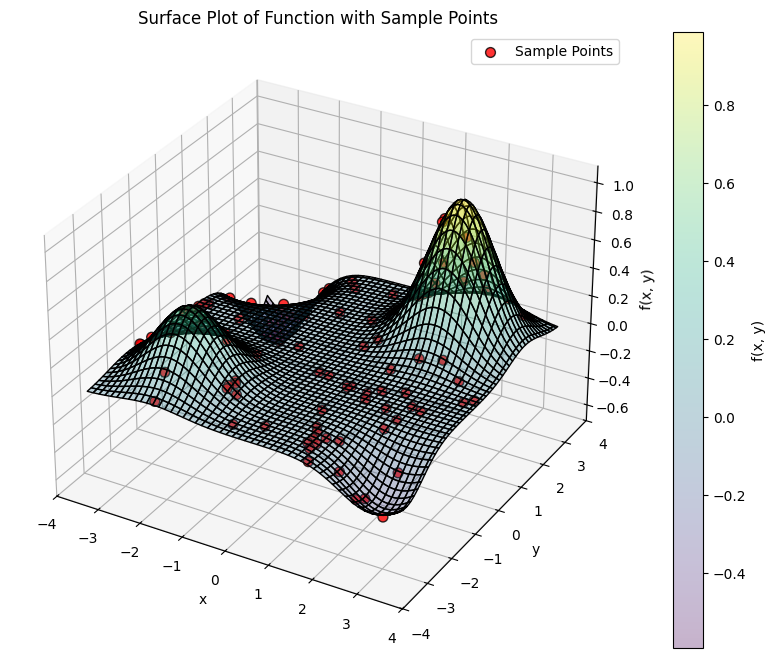

In [4]:
def plot_surface_with_samples(function, bounds, X_sample, y_sample, grid_size=100, noise=0):

    x = np.linspace(bounds[0][0], bounds[0][1], grid_size)
    y = np.linspace(bounds[1][0], bounds[1][1], grid_size)
    X, Y = np.meshgrid(x, y)
    Z = function(np.c_[X.ravel(), Y.ravel()], noise=noise).reshape(X.shape)

    # Plot the surface and sample points
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Surface plot of the function
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k', alpha=0.3)

    # Scatter plot of sample points
    ax.scatter(X_sample[:, 0], X_sample[:, 1], y_sample, color='red', s=50, alpha=0.8, edgecolor='k', label='Sample Points')

    # Add labels and title
    ax.set_title("Surface Plot of Function with Sample Points")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("f(x, y)")
    fig.colorbar(surf, ax=ax, label="f(x, y)")
    plt.legend()
    plt.show()

np.random.seed(12345678)
n_samples = 100
bounds = np.array([[-3.5, 3.5],[-3.5,3.5]])
X_train, y_train = generate_data(black_box_function=black_box_function, range = bounds, n_samples=n_samples,noise=0.01)
plot_surface_with_samples(black_box_function, bounds, X_train, y_train, grid_size=100, noise=0)

<h1> Gaussian Process Regression Model </h1>

From the structure of the regression model, the posterior distribution of the testing dataset given training dataset is as follows: 

\begin{equation*}
y=h\left(x\right)+\varepsilon
\end{equation*}

\begin{equation*}
\begin{bmatrix}
    \vec{y}_{train} \\
    \vec{y}_{test}
\end{bmatrix}
\Bigg| X_{train}, X_{test} =
\begin{bmatrix}
    \vec{h}_{train} \\
    \vec{h}_{test}
\end{bmatrix}
\Bigg| X_{train}, X_{test}
+ 
\begin{bmatrix}
    \vec{\epsilon}_{train} \\
    \vec{\epsilon}_{test}
\end{bmatrix}
\Bigg| X_{train}, X_{test}
\sim \mathcal{N} \left( 
\vec{0},
\begin{bmatrix}
    K(X_{train}, X_{train}) + \sigma^2 I & K(X_{train}, X_{test}) \\
    K(X_{test}, X_{train}) & K(X_{test}, X_{test}) + \sigma^2 I
\end{bmatrix}
\right)
\end{equation*}

Remember in the basic statistics review, the posterior distribution of normally distributed variable given another normally distributed variable has a known form of expression

\begin{equation*}
\vec{y}_{test} \mid \vec{y}_{train}, X_{train}, X_{test} \sim \mathcal{N}(\mu^*, \Sigma^*)
\end{equation*}

where

\begin{align*}
\mu^* &= K(X_{test}, X_{train})(K(X_{train}, X_{train}) + \sigma^2 I)^{-1} \vec{y} \\
\Sigma^* &= K(X_{test}, X_{test}) + \sigma^2 I - K(X_{test}, X_{train})(K(X_{train}, X_{train}) + \sigma^2 I)^{-1} K(X_{train}, X_{test})
\end{align*}


In [5]:
class GaussianProcessRegression:

    def __init__(self, noise_variance=1e-8, name_kernel="rbf", length_scale=1.0):
        self.noise_variance = noise_variance
        self.length_scale = length_scale
        self.X_train, self.y_train = None, None
        self.K = None
        self.func_mu, self.func_cov = None, None

        self.set_kernel(name_kernel=name_kernel)

    def set_kernel(self, name_kernel):
        if name_kernel == "rbf":
            self.kernel = self.rbf_kernel
        elif name_kernel == "matern32":
            self.kernel = self.matern32_kernel
        else:
            warnings.warn(f"Warning: '{name_kernel}' is not a valid option. Please try 'rbf' or 'matern32'.")


    # Radial Basis Kernel
    def rbf_kernel(self, X1, X2):
        sqdist = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
        return np.exp(-0.5 * sqdist / self.length_scale**2)

    # Matern 3/2 Kernel
    def matern32_kernel(self, X1, X2):
        # Calculate pairwise Euclidean distance
        sqdist = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
        dists = np.sqrt(np.maximum(sqdist, 0))  # Ensure non-negative values

        # Apply the Matérn 3/2 kernel formula
        scaled_dists = np.sqrt(3) * dists / self.length_scale
        return (1 + scaled_dists) * np.exp(-scaled_dists)

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.K = self.kernel(self.X_train, self.X_train) + self.noise_variance * np.eye(len(self.X_train))

    # GPR posterior distribution prediction of mean and covariance function
    def predict(self, X_test):
        # Covariance between training and test points
        K_s = self.kernel(self.X_train, X_test)
        # Covariance for the test points
        K_ss = self.kernel(X_test, X_test) + self.noise_variance * np.eye(len(X_test))
        

        # Compute the mean of the predictive distribution
        K_inv = np.linalg.inv(self.K)
        self.func_mu = K_s.T @ K_inv @ self.y_train
        # Compute the variance of the predictive distribution
        self.func_cov = K_ss - K_s.T @ K_inv @ K_s
        
        return self.func_mu, self.func_cov

<h1> Acquisition Functions (Important) </h1>

Acquisition functions are essential in Batch Bayesian Optimization as they guide the selection of multiple points simultaneously, balancing exploration and exploitation. Key acquisition functions in BBO include Multi-Point Expected Improvement (q-EI), which maximizes the total improvement across the batch while avoiding redundant points, and Batch Upper Confidence Bound (BUCB), which selects points based on a trade-off between predicted mean and uncertainty.

<h3> Multi-point Expected Improvement (q-EI) </h3>

The multi-point expected improvement acquisition function aims to maximize the total expected improvement from the batch of samples. For a single batch size $q = 1$, this expression recovers the "standard" expected improvment acquisition function from the previous tutorial as $\mathop{\operatorname{max}}\limits_{i \in \{1,2,...,q\}}\left[f(\mathbf{x}_i) - f^*, 0\right] = \mathop{\operatorname{max}}\left[f(\mathbf{x}_0) - f^*, 0\right]$.

$$
qEI(\mathbf{X}) = \mathbb{E}\left[\mathop{\operatorname{max}}\limits_{i \in \{1,2,...,q\}}\{f(\mathbf{x}_i) - f^*, 0\}\right]
$$

Unlike the single-point expected improvement acquisition function, which has a closed-form analytical expression, the same cannot be said for batch sizes greater than 2. In such cases, the integration over high-dimensional spaces becomes computationally intractable. Consequently, a popular research direction is to approximate the acquisition function using various methods. One common approach is through Monte Carlo simulation, where the average of the sampled improvements converges to the expected improvement as the number of samples increases, by the law of large numbers.

$$

qEI(\mathbf{X}) \approx \frac{1}{N} \sum_{i=1}^N \max _{j=1, \ldots, q}\left\{\max \left(\xi_{i j}-f^*, 0\right)\right\}, \text { where } \xi_i \sim \mathbb{P}(f(X) \mid \mathcal{D})
$$

By using the reparameterization technique via the Cholesky decomposition of the posterior covariance matrix, one can sample the function values at the locations of the batch from the same sampled function. With the Cholesky decomposition, $ \mathbf{L}(X)\mathbf{L}(X)^\top = \Sigma(X) $, and $ \mu(X) + \mathbf{L}(X) \epsilon_i \sim \mathcal{N}(\mu(X), \mathbf{L}(X) \mathbf{L}(X)^\top) = \mathcal{N}(\mu(X), \Sigma(X)) $, where $ \epsilon_i \sim \mathcal{N}(0, I) $.

$$
\mathrm{qEI}(X) \approx \frac{1}{N} \sum_{i=1}^N \max _{j=1, \ldots, q}\left\{\max \left(\mu(X)_j+\left(L(X) \epsilon_i\right)_j-f^*, 0\right)\right\}, \quad \epsilon_i \sim \mathcal{N}(0, I)
$$

<h3> Batch Upper Confdience Bound </h3>

Batch Upper Confidence Bound (BUCB) employs the same acquisition function as the standard Upper Confidence Bound (UCB). However, in BUCB, a batch is constructed sequentially by iteratively fitting the Gaussian Process regression model on a temporary dataset augmented with "hallucinated" data. Hallucinated data is generated by predicting the mean function values at the selected batch points and treating these predictions as observed data with zero variance. This process suppresses the peaks of the UCB acquisition function by reducing the uncertainty (variance) at the hallucinated points, thereby encouraging exploration of new regions for subsequent batch elements.

$$
\alpha_{k}(\mathbf{x} \mid \mathcal{D}) = \text{UCB}(\mathbf{x}\mid \mathcal{D}_{k}; \lambda) = \mu(\mathbf{x} \mid \mathcal{D}_{k}) + \lambda \sigma(\mathbf{x} \mid \mathcal{D}_{k}), \quad  where \quad  k \in \{1,2,...,q\}
$$


In [6]:
class AcquisitionFunction:

    def __init__(self):
        pass

    def get_function(self, name=None):
        self.name = name

        if self.name == "thompson_sampling":
            return self.thompson_sampling
        elif self.name == "upper_confidence_bound" or self.name == "batch_upper_confidence_bound":
            return self.upper_confidence_bound
        elif self.name == "q_expected_improvement":
            return self.q_expected_improvement
        else:
            warnings.warn(f"Warning: '{self.name}' is not a valid option. Returning None.")
            return None


    def thompson_sampling(self, X, X_sample, gpr, n_batch):
        mu_domain, cov_domain = gpr.predict(X)

        eigvals, eigvecs = np.linalg.eigh(cov_domain)
        eigvals = np.clip(eigvals, 1e-6, None)
        cov_domain_post = (eigvecs * eigvals) @ eigvecs.T

        func_samples = np.random.multivariate_normal(mu_domain.ravel(), cov_domain_post, n_batch)

        return func_samples
    

    def upper_confidence_bound(self, X, X_sample, gpr, lamb=0.1):
        mu_domain, cov_domain = gpr.predict(X)
        sigma_domain = np.sqrt(np.diag(cov_domain))
        sigma_domain = sigma_domain.flatten()
        
        alpha = mu_domain.flatten() + lamb*sigma_domain
        alpha = alpha.flatten()

        return alpha
    
    def q_expected_improvement(self, X, X_sample, gpr, xi=0.01, n_simulation=100):
        mu_domain, cov_domain = gpr.predict(X)
        L = np.linalg.cholesky(cov_domain)

        mu_sample, _ = gpr.predict(X_sample)
        mu_sample_optimal = np.max(mu_sample)

        n_batch = mu_domain.shape[0]
        q_improvement_array = np.zeros(n_simulation)
        for i in range(n_simulation):
            z = np.random.randn(1, n_batch) 
            mu_batch = mu_domain + z @ L.T

            mu_batch_max = np.max(mu_batch)
            q_improvement_array[i] = np.max([mu_batch_max - mu_sample_optimal - xi,0])

        q_improvement_average = 1/n_simulation * np.sum(q_improvement_array)
        return q_improvement_average
    
    def expected_improvement(self, X, X_sample, gpr, xi=0.01):
        mu_domain, cov_domain = gpr.predict(X)
        sigma_domain = np.sqrt(np.diag(cov_domain))
        sigma_domain = sigma_domain.flatten()
        
        mu_sample, _ = gpr.predict(X_sample)
        mu_sample_optimal = np.max(mu_sample)

        with np.errstate(divide="warn"):
            improvement = mu_domain - mu_sample_optimal - xi
            improvement = improvement.flatten()
            Z = improvement/sigma_domain
            
            ei = improvement * norm.cdf(Z) + sigma_domain * norm.pdf(Z)
            ei[sigma_domain == 0.0] = 0.0

        return ei

In [7]:
class PlottingHelper:
    def __init__(self, bayesian_optimization_instance):
        self.bo_instance = bayesian_optimization_instance
        self.scale = 0.6

        grid_size = 50
        x = np.linspace(-3.5, 3.5, grid_size)
        y = np.linspace(-3.5, 3.5, grid_size)
        self.X, self.Y = np.meshgrid(x, y)

    def plot_contour(self, X_next, iter, gpr):
        mu_domain, cov_domain = gpr.predict(self.bo_instance.X_test)
        var_domain = np.diag(cov_domain)

        n_plots = 3 if self.bo_instance.name == "batch_upper_confidence_bound" else 2
        figsize = (14, 4) if self.bo_instance.name == "batch_upper_confidence_bound" else (14, 6)
        plt.figure(figsize=figsize)

        # Define color scale for consistency in contour plots
        vmin, vmax = -0.8, 1

        # First subplot (Mean Plot)
        plt.subplot(1, n_plots, 1)
        contour = plt.contourf(self.bo_instance.X, self.bo_instance.Y, mu_domain.reshape(self.bo_instance.X.shape), levels=50, cmap="viridis", vmin=vmin, vmax=vmax)
        plt.scatter(X_next[:, 0], X_next[:, 1], color="black", edgecolor="white", s=50, alpha=0.8)
        plt.colorbar(contour, label="f(x, y)")
        plt.title(f"Mean Function [Iteration {iter}]")
        plt.ylabel("y")
        plt.xlabel("x")

        # Second subplot (Variance Plot)
        plt.subplot(1, n_plots, 2)
        contour_temp = plt.contourf(self.X, self.Y, var_domain.reshape(self.bo_instance.X.shape), levels=50, cmap="viridis")
        plt.scatter(X_next[:, 0], X_next[:, 1], color="black", edgecolor="white", s=50, alpha=0.8)
        plt.colorbar(contour_temp, label="f(x, y)")
        plt.title(f"Variance [Iteration {iter}]")
        plt.ylabel("y")
        plt.xlabel("x")

        if self.bo_instance.name == "batch_upper_confidence_bound":
            plt.subplot(1, 3, 3)
            contour_temp = plt.contourf(self.X, self.Y, mu_domain.reshape(self.bo_instance.X.shape) + 1 * var_domain.reshape(self.bo_instance.X.shape), levels=50, cmap="viridis", vmin=vmin, vmax=vmax)
            plt.scatter(X_next[:, 0], X_next[:, 1], color="black", edgecolor="white", s=50, alpha=0.8)
            plt.colorbar(contour_temp, label="f(x, y)")
            plt.title(f"Upper Confidence Bound [Iteration {iter}]")
            plt.ylabel("y")
            plt.xlabel("x")

        plt.tight_layout()  # To ensure there's no overlap between subplots
        plt.show()

    def plot_surface(self, X_next, iter, gpr):
        grid_size = 100
        x = np.linspace(self.bo_instance.bounds[0][0], self.bo_instance.bounds[0][1], grid_size)
        y = np.linspace(self.bo_instance.bounds[1][0], self.bo_instance.bounds[1][1], grid_size)
        X, Y = np.meshgrid(x, y)

        # Get mean and covariance predictions
        Z, Z_cov = gpr.predict(np.c_[X.ravel(), Y.ravel()])
        Z = Z.reshape(X.shape)
        Z_var = np.diag(Z_cov).reshape(X.shape)

        # Create a 1x2 subplot
        fig, axs = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={'projection': '3d'})

        # Plot the mean surface on the first subplot
        surf_mean = axs[0].plot_surface(X, Y, Z , cmap='viridis', edgecolor='k', alpha=0.3)
        axs[0].scatter(X_next[:, 0], X_next[:, 1], np.zeros(len(X_next)), color='red', s=50, alpha=0.8, edgecolor='k', label='Sample Points')
        axs[0].set_title(f"Mean Function [Iteration {iter}]")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("y")
        axs[0].set_zlabel("Mean f(x, y)")
        fig.colorbar(surf_mean, ax=axs[0], label="f(x, y)")

        # Plot the variance surface on the second subplot
        surf_var = axs[1].plot_surface(X, Y, Z_var, cmap='plasma', edgecolor='k', alpha=0.3)
        axs[1].scatter(X_next[:, 0], X_next[:, 1], np.zeros(len(X_next)), color='red', s=50, alpha=0.8, edgecolor='k', label='Sample Points')
        axs[1].set_title(f"Variance of Predictions [Iteration {iter}]")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("y")
        axs[1].set_zlabel("Variance")
        fig.colorbar(surf_var, ax=axs[1], label="Variance")

        plt.tight_layout()
        plt.show()

    def plot_convergence(self, X_sample, Y_sample, n_init=2, index_start=None):
        plt.figure(figsize=(14*self.scale, 6*self.scale))

        x = X_sample[n_init:]
        y = Y_sample[n_init:].ravel()
        r = range(1, len(x)+1)
        
        x_neighbor_dist = [np.linalg.norm(a-b) for a, b in zip(x, x[1:])]
        print(y.shape, Y_sample.shape)
        y_max_watermark = np.maximum.accumulate(y)

        plt.subplot(1, 2, 1)
        plt.plot(r[1:], x_neighbor_dist, 'bo-')
        plt.xlabel('Iteration')
        plt.ylabel('Distance')
        plt.title('Distance between consecutive x\'s')

        plt.subplot(1, 2, 2)
        plt.plot(r, y_max_watermark, 'ro-')
        if index_start is not None:
            for i_iter_start in index_start:
                plt.axvline(x=i_iter_start, color='black', linestyle='--', lw=2, label="Next sampling point")
        plt.xlabel('Iteration')
        plt.ylabel('Best Y')
        plt.title('Value of best selected sample')


In [8]:
class BayesianOptimization:

    def __init__(self, black_box_function, gpr, acquisition_function, bounds, noise, name):
        self.black_box_function = black_box_function
        self.gpr = gpr
        self.n_init = len(self.gpr.y_train)
        self.acquisition_function = acquisition_function
        self.X_train = gpr.X_train
        self.y_train = gpr.y_train
        self.bounds = bounds
        self.noise = noise
        self.name = name
        self.dim = self.X_train.shape[1]

        # Grid points within the square domain for Thompson sampling
        grid_size = 50
        x = np.linspace(bounds[0,0], bounds[0,1], grid_size)
        y = np.linspace(bounds[1,0], bounds[1,1], grid_size)
        self.X, self.Y = np.meshgrid(x, y)
        self.X_test = np.column_stack([self.X.ravel(), self.Y.ravel()])

        # List of sequential and batch acquisition functions
        self.sequential_list = ["expected_improvement", "probability_of_improvement", "upper_confidence_bound"]
        self.batch_list = ["thompson_sampling", "batch_upper_confidence_bound", "q_expected_improvement"]

        # Visualise optimisation results
        self.plotter = PlottingHelper(self)


    def objective_function(self, X, model=None):
        if model is None:
            model = self.gpr
        results = None
        
        if self.name == "expected_improvement":
            results = -self.acquisition_function(X.reshape(-1, self.dim), model.X_train, model, xi=0.01)
        elif self.name == "q_expected_improvement":
            results = -self.acquisition_function(X.reshape(-1, self.dim), model.X_train, model, xi=0.01, n_simulation=100)
        elif self.name == "probability_of_improvement":
            results = -self.acquisition_function(X.reshape(-1, self.dim), model.X_train, model, xi=0.01)
        elif self.name == "upper_confidence_bound" or self.name == "batch_upper_confidence_bound":
            results = -self.acquisition_function(X.reshape(-1, self.dim), model.X_train, model, lamb=1.0)
        else:
            warnings.warn(f"Warning: '{self.name}' is not a valid option. Returning None.")
            
        return results

    def probe_next_location(self, n_restarts=25, model=None):
        min_val = 10
        min_x = None

        # Find the best optimum by starting from n_restart different random points.
        for x0 in np.random.uniform(self.bounds[:, 0], self.bounds[:, 1], size=(n_restarts, self.dim)):
            res = minimize(self.objective_function, x0=x0, bounds=self.bounds, method='L-BFGS-B', args=(model))
            if res.fun < min_val:
                min_val = res.fun
                min_x = res.x    
        return min_x.reshape(-1, self.X_test.shape[1])

    def probe_next_location_batch(self, n_batch):

        if self.name=="thompson_sampling":

            func_samples = self.acquisition_function(self.X_test, self.gpr.X_train, self.gpr, n_batch)
            
            # Avoid any duplicate points
            y_samples_max_idx = np.argmax(func_samples, axis=1)
            y_samples_max_idx_filtered = np.unique(y_samples_max_idx)

            if len(y_samples_max_idx) != len(y_samples_max_idx_filtered):
                warnings.warn(f"{len(y_samples_max_idx) - len(y_samples_max_idx_filtered)} points has been filtered for identical coordinate index")

            X_next = self.X_test[y_samples_max_idx_filtered]

        elif self.name=="batch_upper_confidence_bound":
            
            X_halucinate = self.X_train
            y_halucinate = self.y_train
            gpr_halucinate = self.gpr

            X_next = []
            for i in range(n_batch):

                gpr_halucinate.fit(X_train=X_halucinate,y_train=y_halucinate)
                x_next = self.probe_next_location(n_restarts=20, model=gpr_halucinate)
                y_next, _ = gpr_halucinate.predict(x_next.reshape(-1, self.dim))

                # print(f"{X_halucinate.shape}, {X_}")
                X_halucinate = np.vstack((X_halucinate, x_next))
                y_halucinate = np.hstack((y_halucinate, y_next))
                X_next.append(x_next)

            X_next = np.array(X_next)

        elif self.name=="q_expected_improvement":
            min_val = np.inf
            min_x = None

            # Find the best optimum by starting from n_restart different random points.
            n_restarts = 50
            for x0 in np.random.uniform(self.bounds[:, 0], self.bounds[:, 1], size=(n_restarts, n_batch, self.dim)):
                x0_flatten = x0.flatten()
                bounds_batch = np.tile(self.bounds, (n_batch, 1))
                res = minimize(self.objective_function, x0=x0_flatten, bounds=bounds_batch, method='L-BFGS-B', args=(self.gpr))
                if res.fun < min_val:
                    min_val = res.fun
                    min_x = res.x    

            X_next = min_x

        return X_next.reshape(-1, self.dim)

    def optimize(self, iter=10, n_batch=5, insight=False):
        
        # self.plot_insight(X_next=None)
        X_next_list, iter_list, gpr_list, index_start_list = [], [], [], [0]
        for i in range(iter):

            self.gpr.fit(self.X_train,self.y_train)
            
            if self.name in self.sequential_list:
                X_next = self.probe_next_location(n_restarts=250)
                y_next = self.black_box_function(X_next, noise=self.noise)

                self.X_train = np.vstack((self.X_train, X_next))
                self.y_train = np.vstack((self.y_train, y_next))
            elif self.name in self.batch_list:
                X_next = self.probe_next_location_batch(n_batch=n_batch)
                y_next = self.black_box_function(X_next, noise=self.noise)

                self.X_train = np.vstack((self.X_train, X_next))
                self.y_train = np.hstack((self.y_train, y_next))

            X_next_list.append(X_next)
            iter_list.append(i)
            index_start_list.append(index_start_list[-1] + len(X_next))
            gpr_list.append(copy.deepcopy(self.gpr))

            print(f"The sampled value so far : {np.max(self.y_train)}")
            if insight:
                self.plotter.plot_contour(X_next, iter=i, gpr=gpr_list[-1])
                # self.plotter.plot_surface(X_next, iter=i, gpr=gpr_list[-1])



        self.plotter.plot_convergence(self.X_train, self.y_train, n_init=self.n_init, index_start=index_start_list)

The sampled value so far : 0.49618551500772584


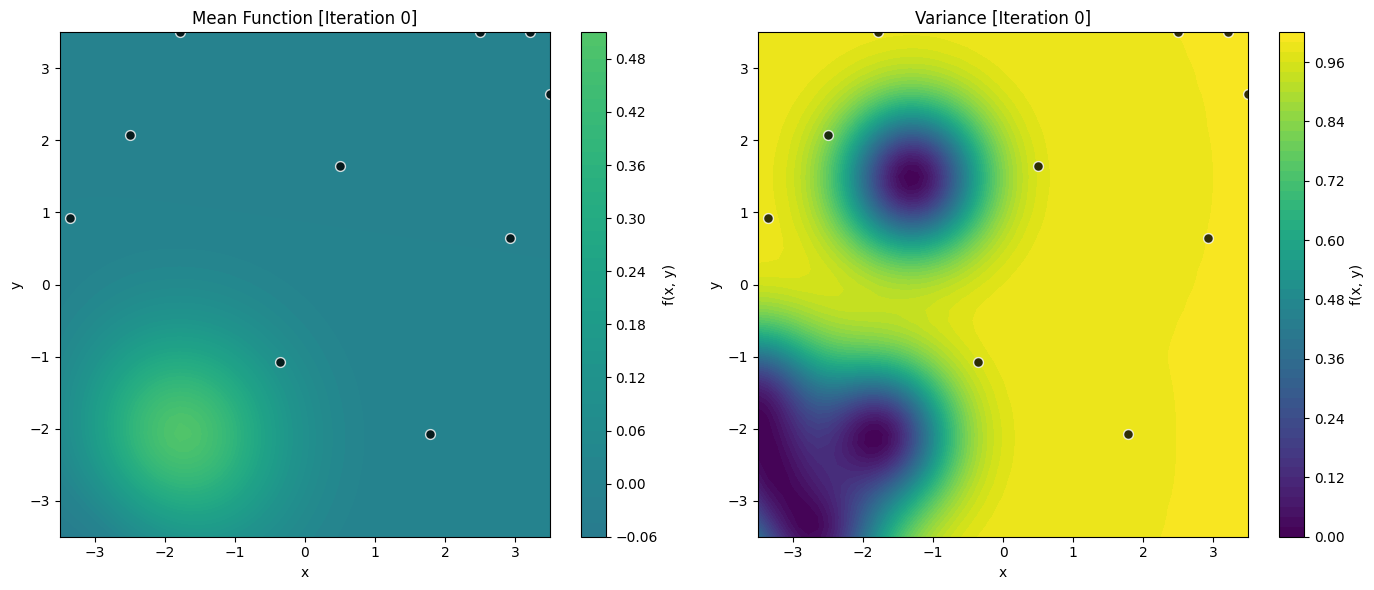

The sampled value so far : 0.49618551500772584


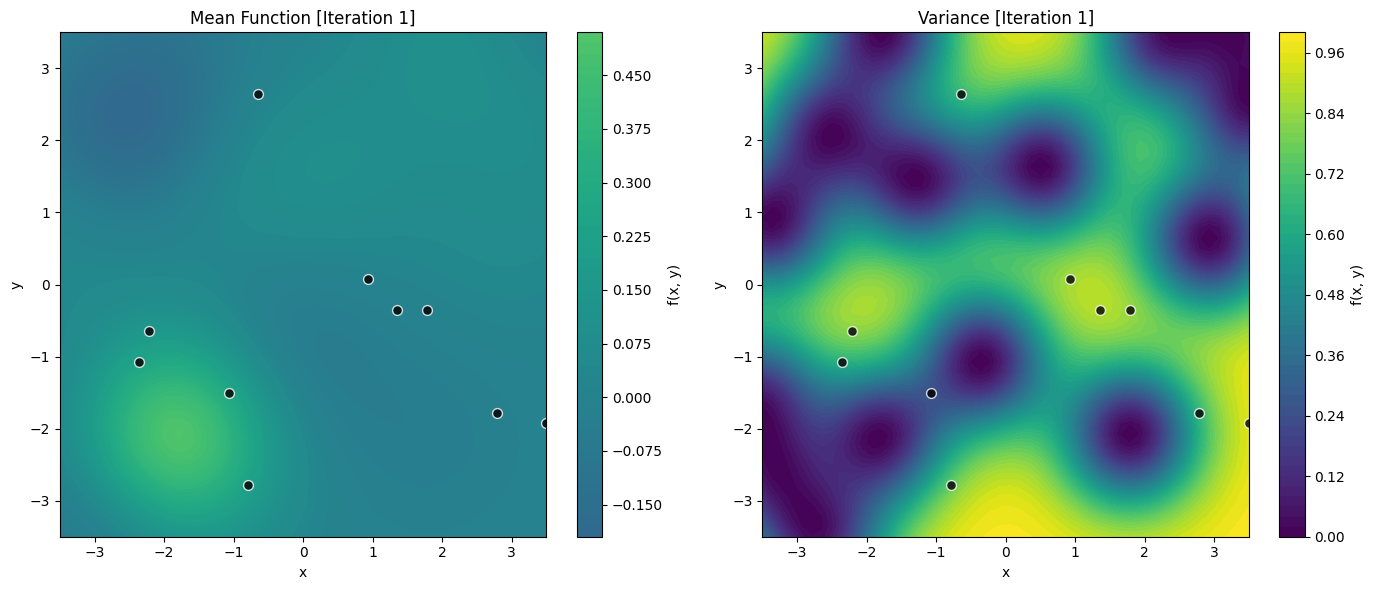

The sampled value so far : 0.8656342559589276


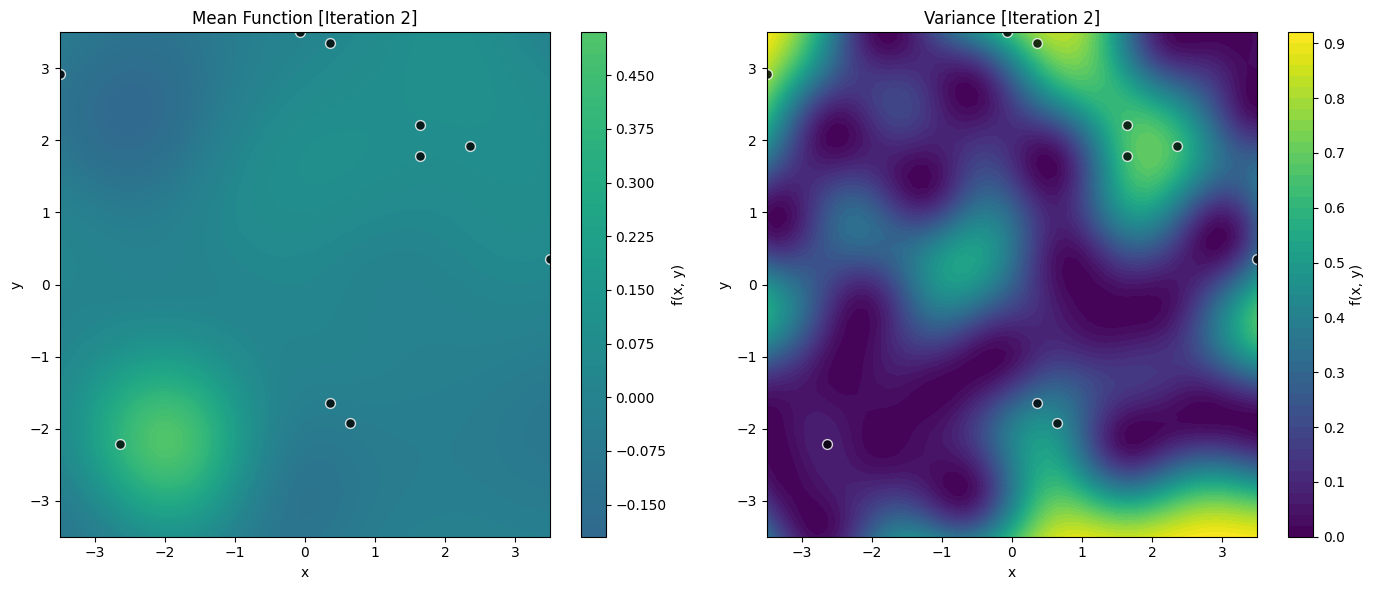

The sampled value so far : 0.9939084452507417


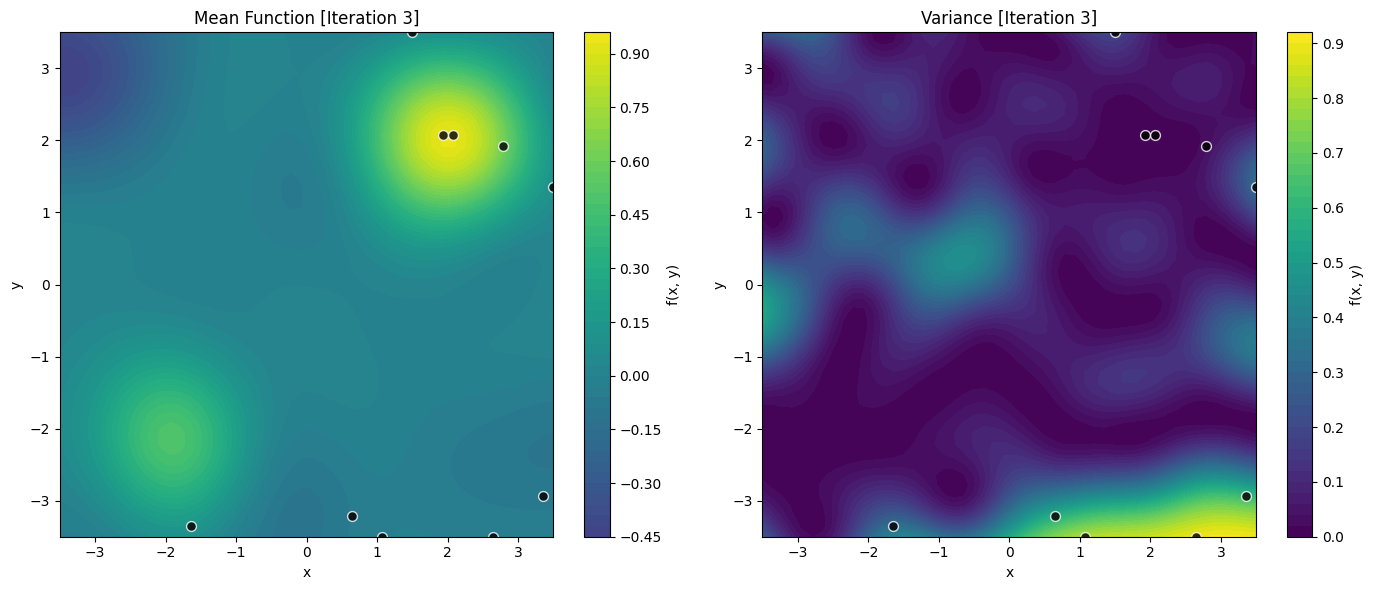

/var/folders/k8/vn4v4n691bj4zyf5fz1mrlk40000gn/T/ipykernel_55935/2880596109.py:71: UserWarning: 5 points has been filtered for identical coordinate index
  warnings.warn(f"{len(y_samples_max_idx) - len(y_samples_max_idx_filtered)} points has been filtered for identical coordinate index")


The sampled value so far : 0.9939084452507417


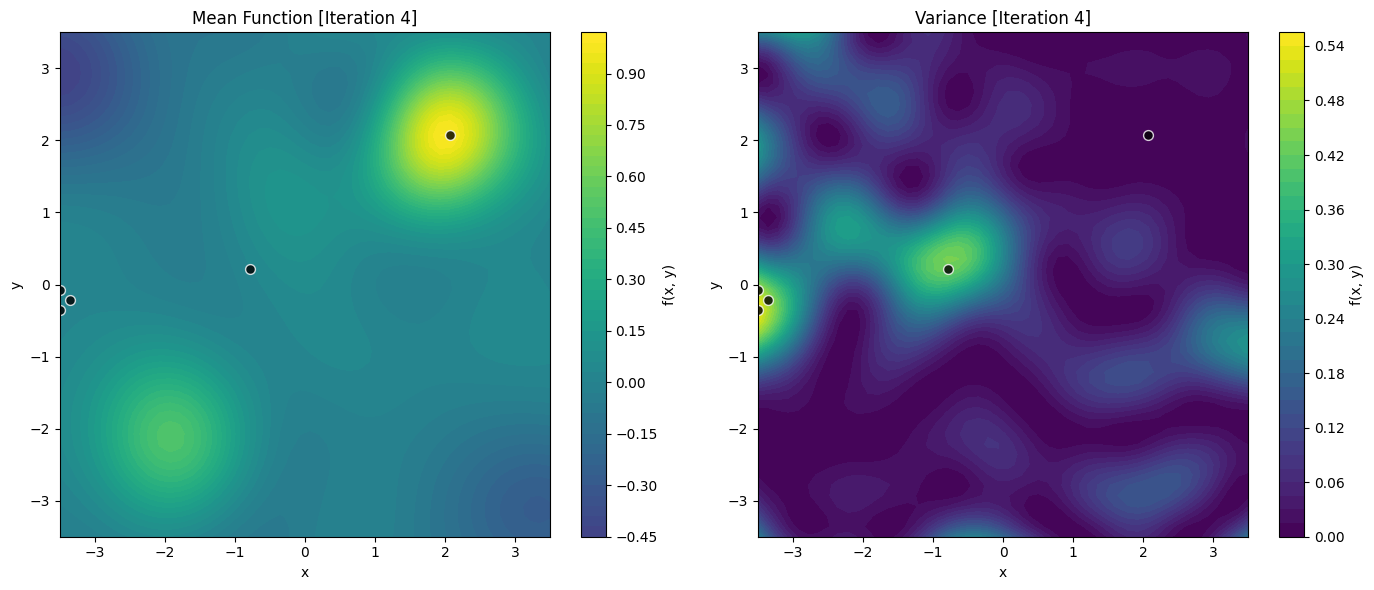

(45,) (50,)


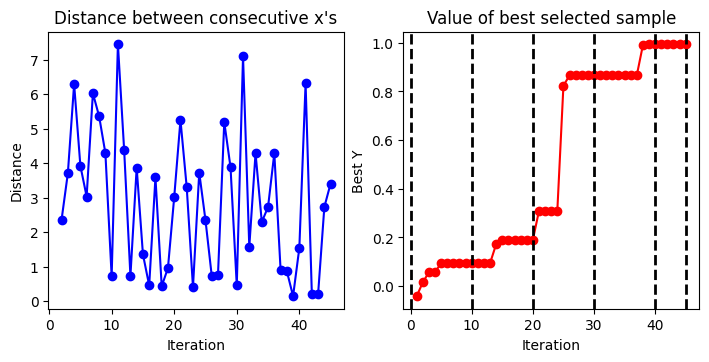

In [9]:
def pipeline(name_acquisition="thompson_sampling", name_kernel="rbf", seed=1, length_scale=1.0, iter=10, n_batch=5, insight=False):
    np.random.seed(seed)
    n_samples = 5
    bounds = np.array([[-3.5, 3.5],[-3.5,3.5]])
    noise = 0.01

    X_train, y_train = generate_data(black_box_function=black_box_function, range = bounds, n_samples=n_samples,noise=noise)
    gpr = GaussianProcessRegression(name_kernel=name_kernel,length_scale=1.0)
    gpr.fit(X_train=X_train,y_train=y_train)
    acquisition_function = AcquisitionFunction()
    thompson_sampling = acquisition_function.get_function(name=name_acquisition)

    bayesian_optimization = BayesianOptimization(black_box_function=black_box_function, gpr=gpr, acquisition_function=thompson_sampling, 
                                                 bounds=bounds, noise=noise, name=name_acquisition)
    bayesian_optimization.optimize(iter=iter, n_batch=n_batch, insight=insight)
    return bayesian_optimization

if __name__ == "__main__":
    name_acquisition = "thompson_sampling"
    # name_acquisition = "batch_upper_confidence_bound"
    name_kernel = "rbf"
    seed = 1234567
    length_scale = 1.0
    iter = 5
    n_batch = 10
    insight = True
    bayesian_optimisation = pipeline(name_acquisition=name_acquisition, name_kernel=name_kernel, seed=seed, length_scale=length_scale, iter=iter, n_batch=n_batch, insight=insight)

The sampled value so far : 0.49618551500772584


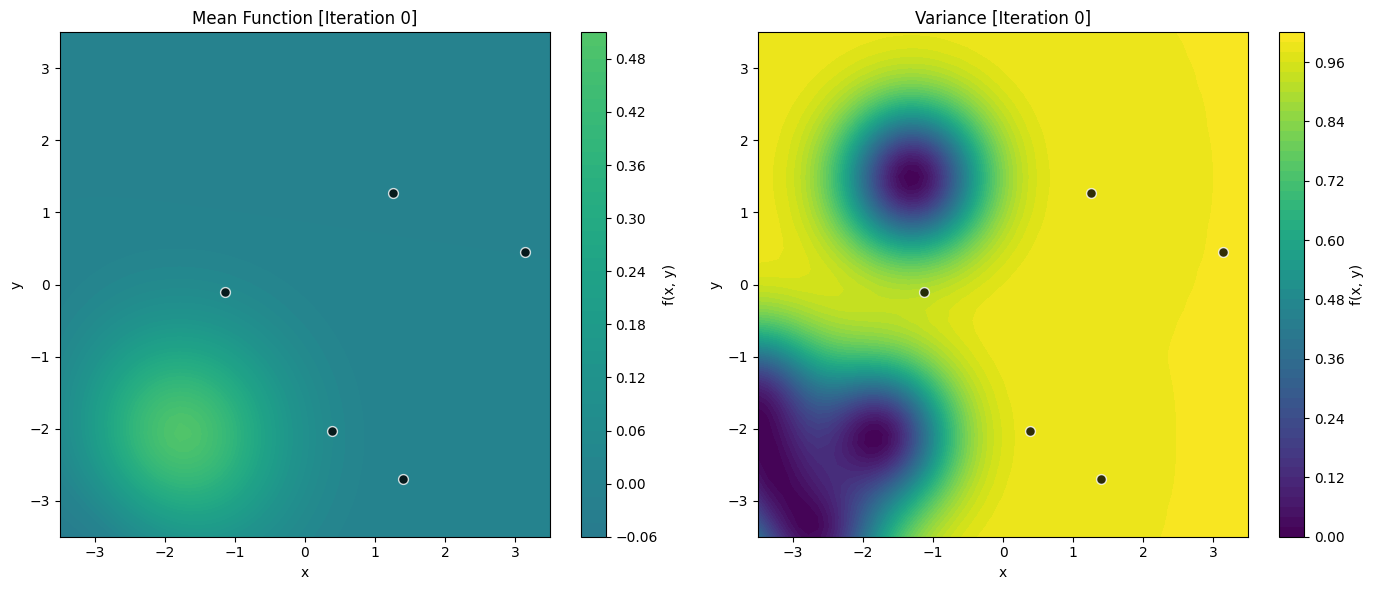

The sampled value so far : 0.49618551500772584


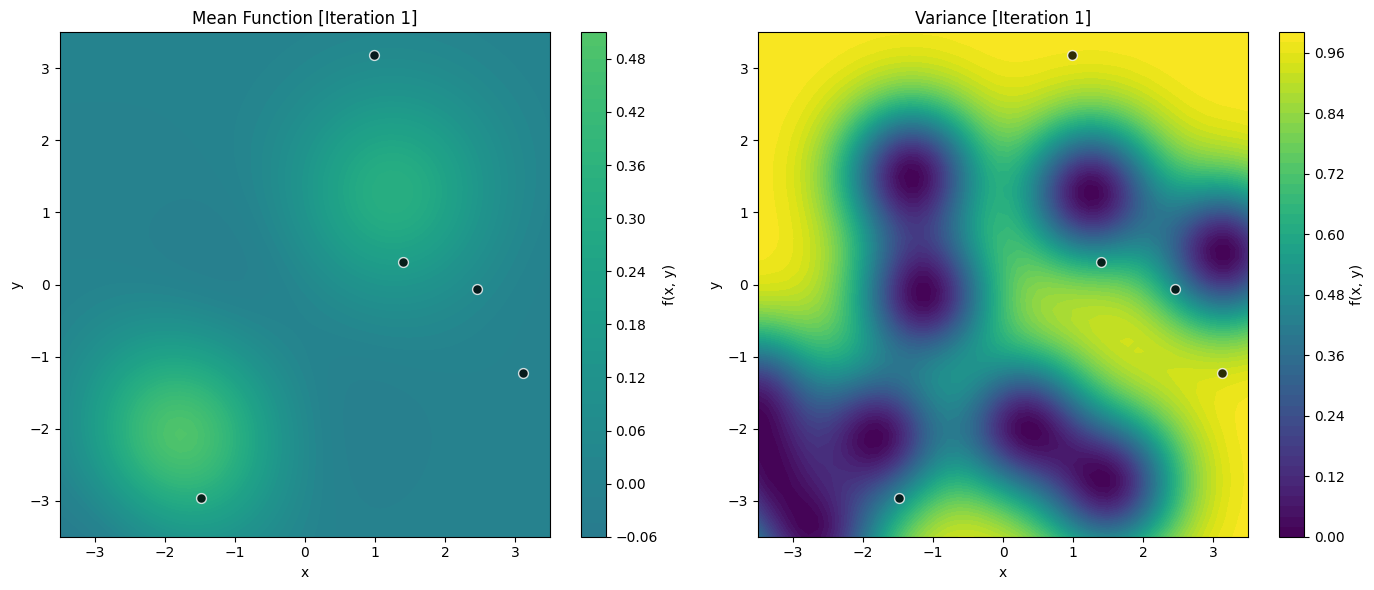

The sampled value so far : 0.49618551500772584


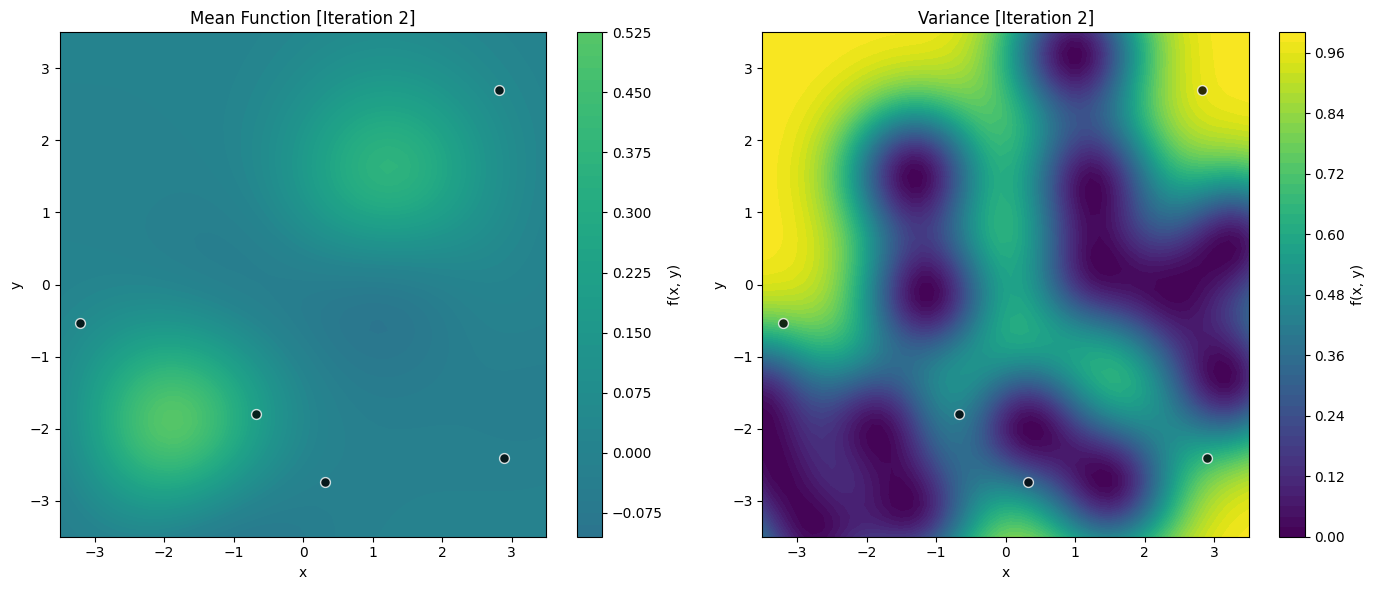

The sampled value so far : 0.5955347153460955


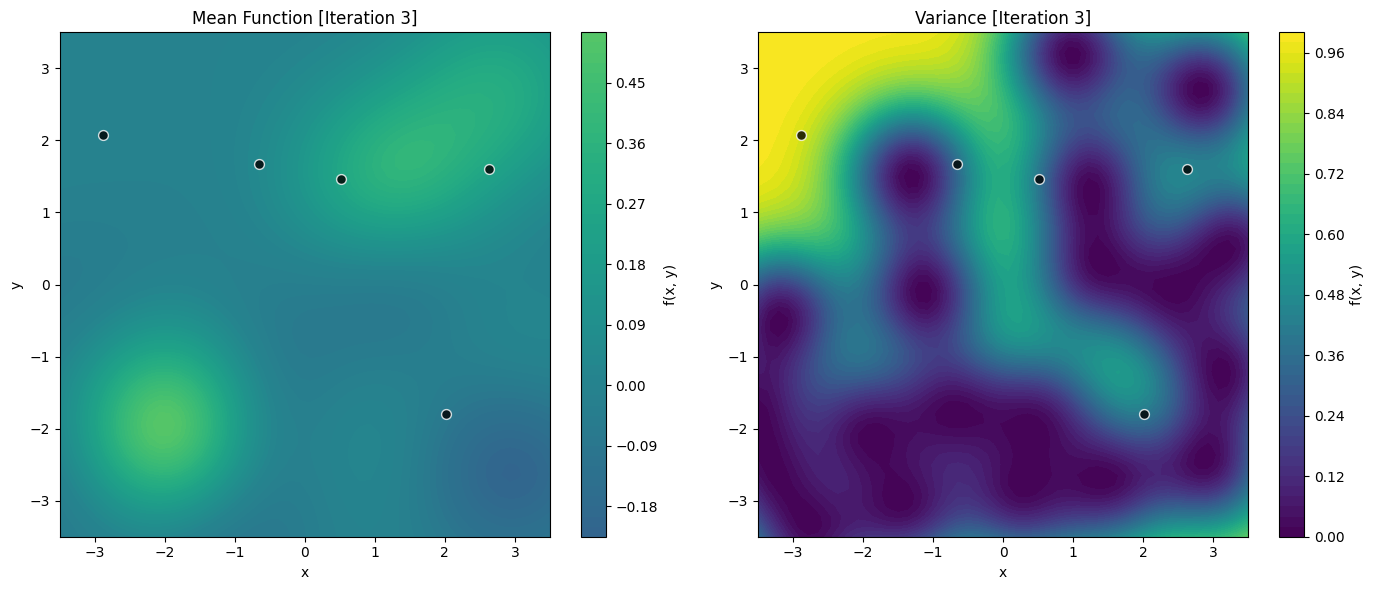

The sampled value so far : 0.5955347153460955


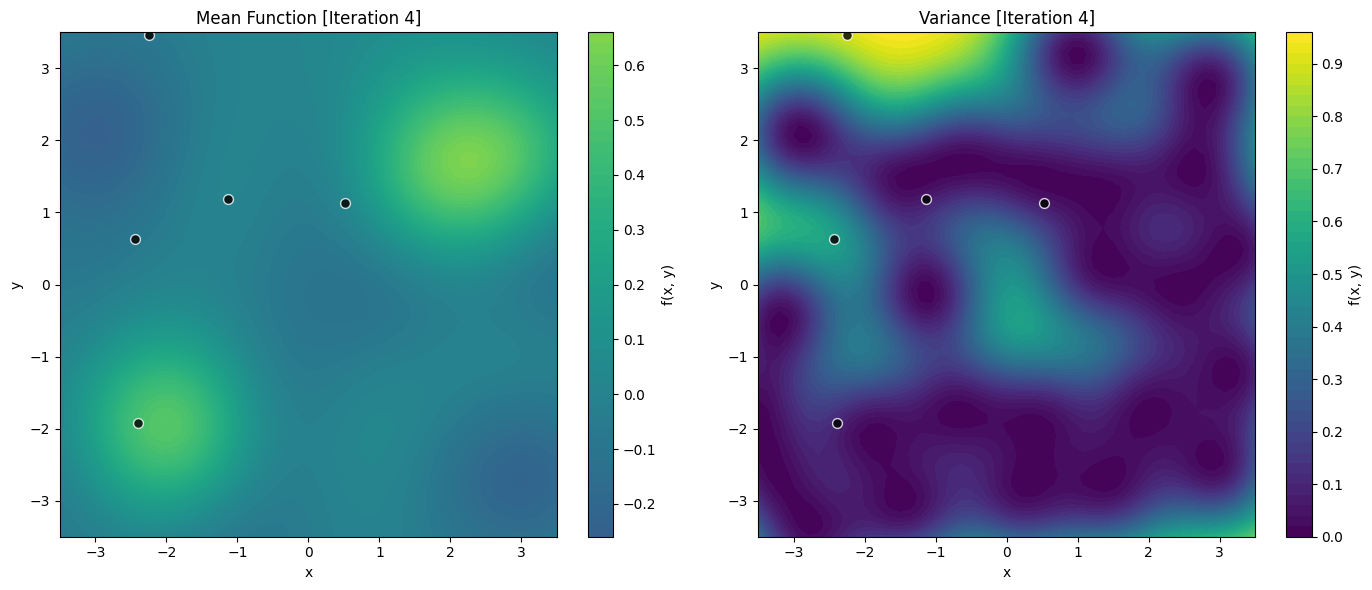

The sampled value so far : 0.7018478199681638


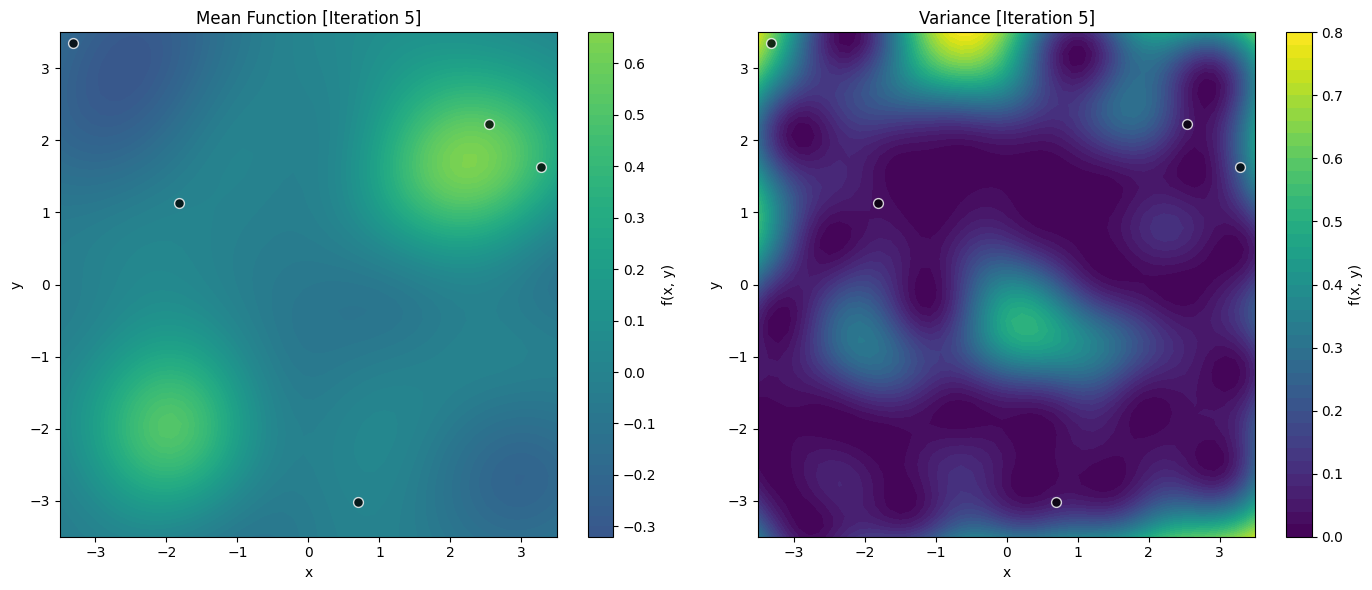

The sampled value so far : 0.9637373686162783


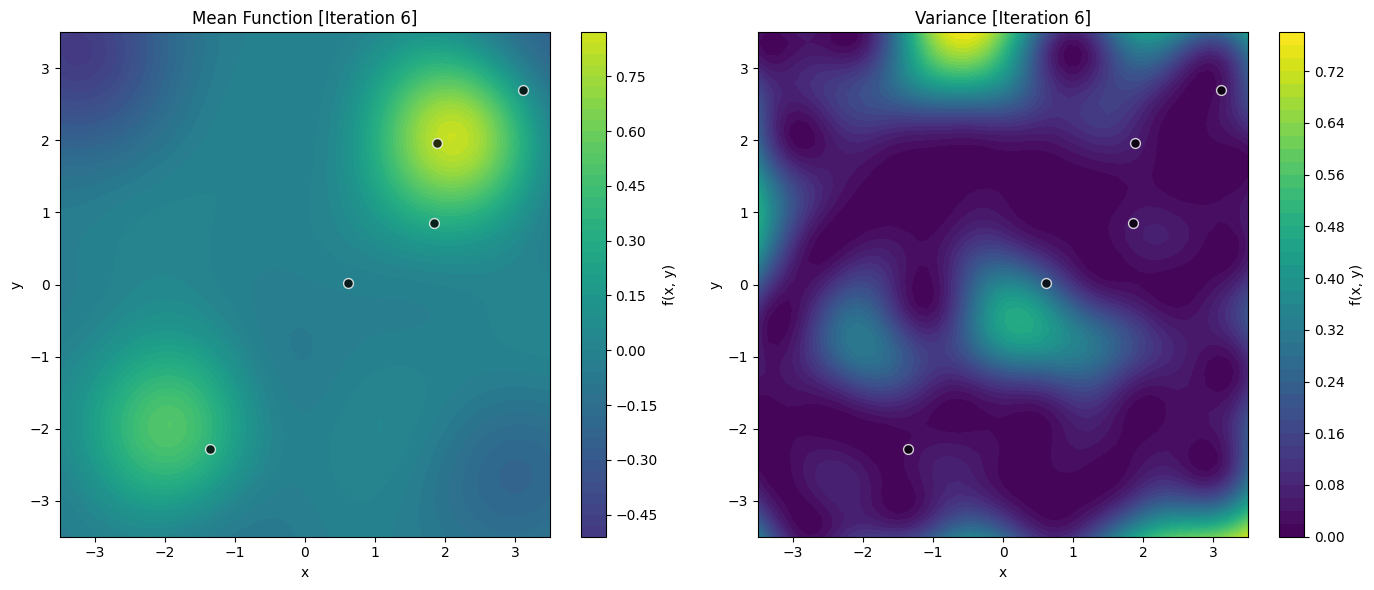

The sampled value so far : 0.9805502861348888


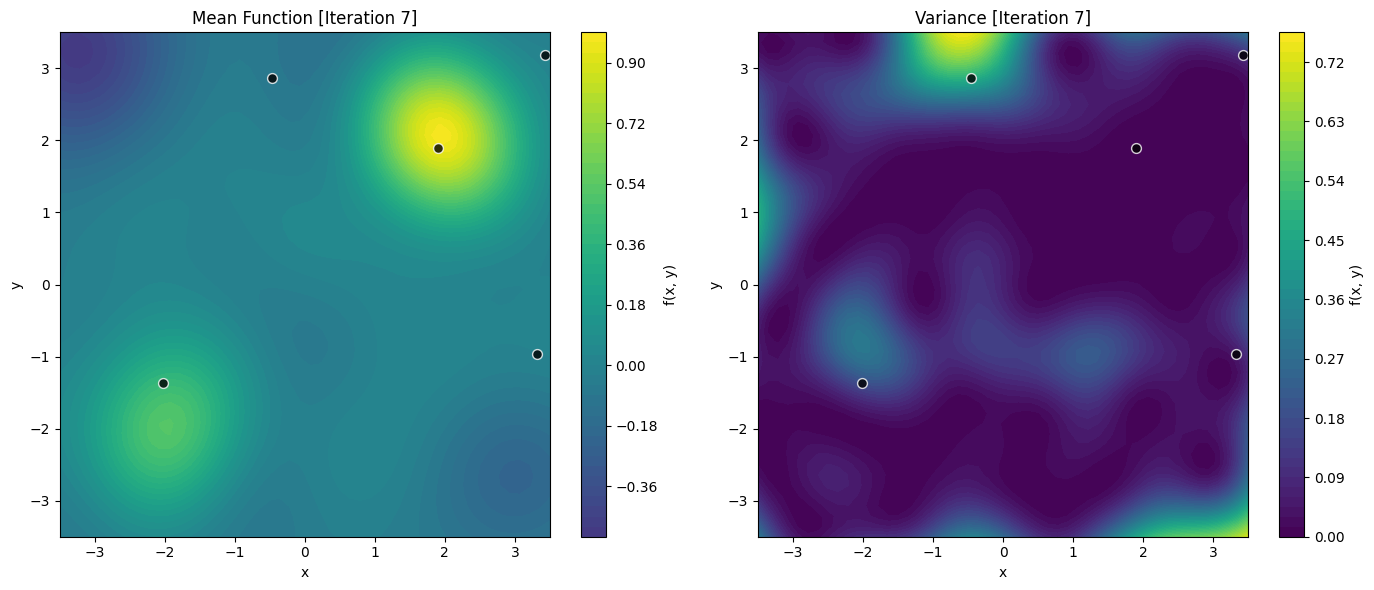

The sampled value so far : 0.9805502861348888


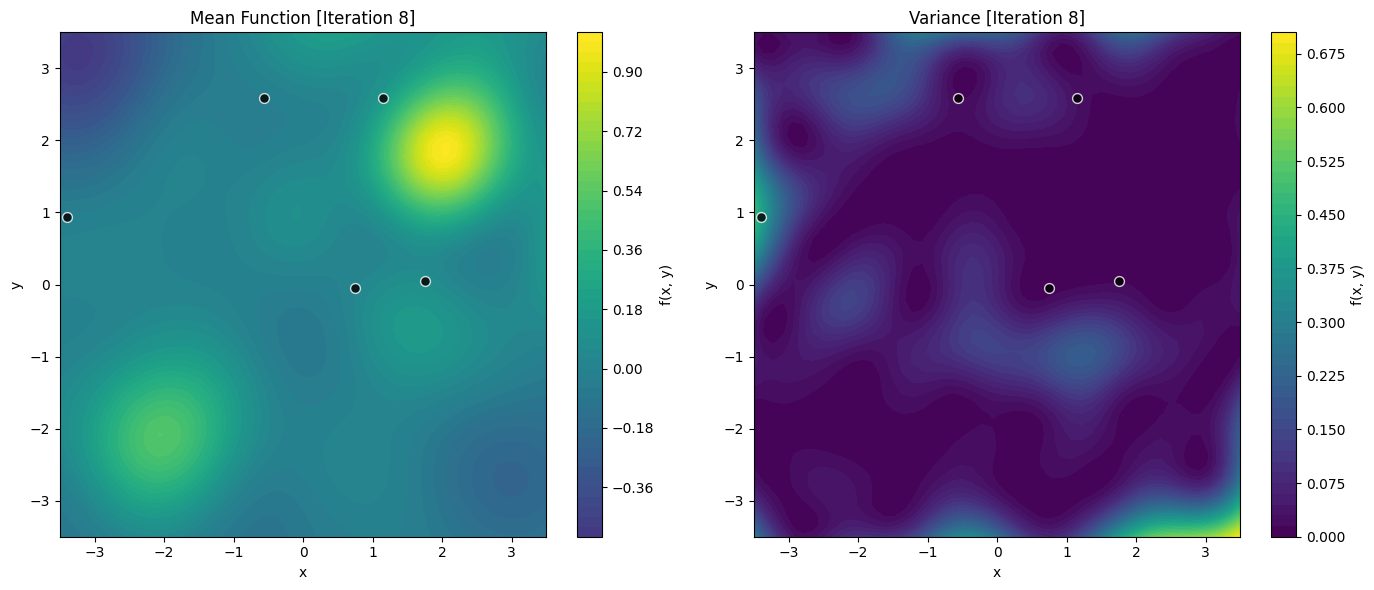

The sampled value so far : 0.9805502861348888


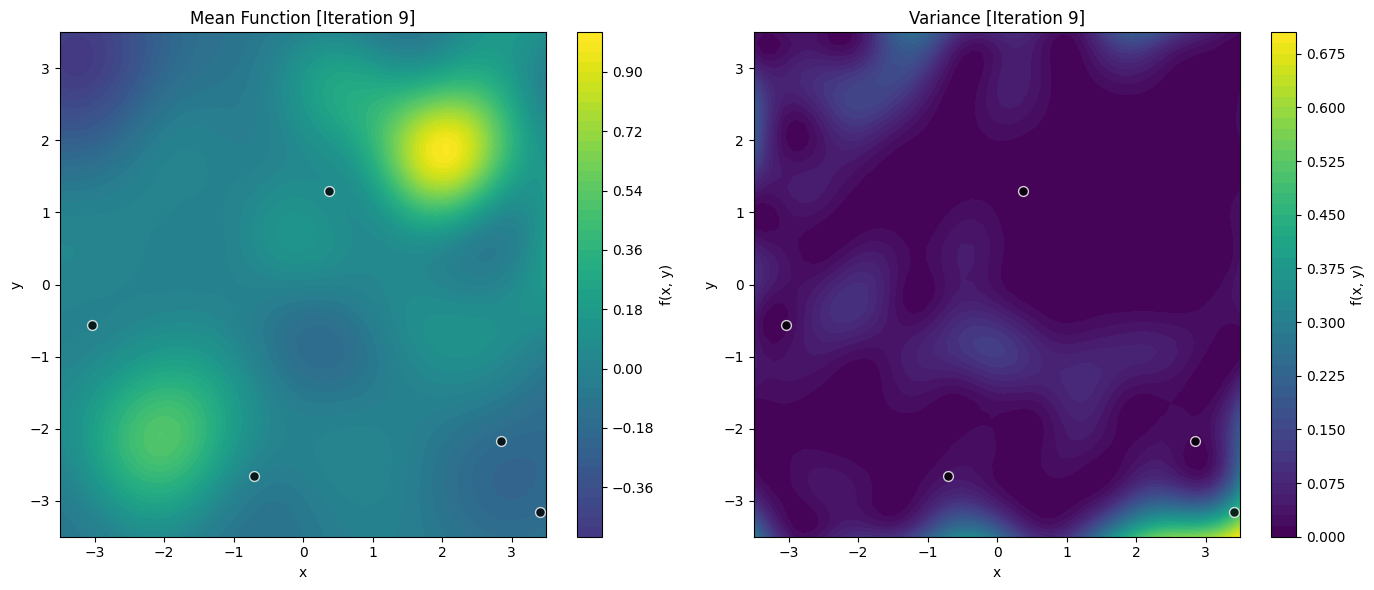

(50,) (55,)


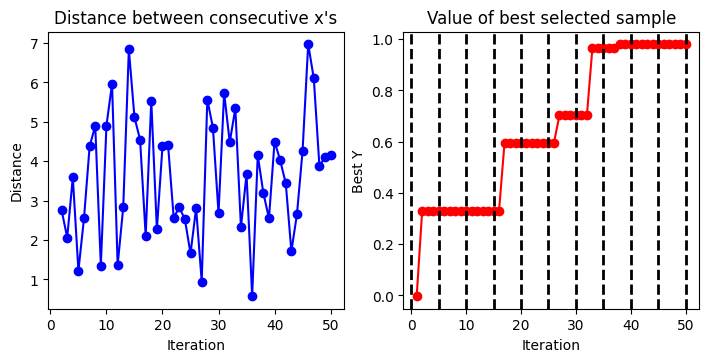

In [10]:
if __name__ == "__main__":
    name_acquisition = "q_expected_improvement"
    name_kernel = "rbf"
    seed = 1234567
    length_scale = 2.0
    iter = 10
    n_batch = 5
    insight = True
    bayesian_optimisation = pipeline(name_acquisition=name_acquisition, name_kernel=name_kernel, seed=seed, length_scale=length_scale, iter=iter, n_batch=n_batch, insight=insight)

The sampled value so far : 0.49618551500772584


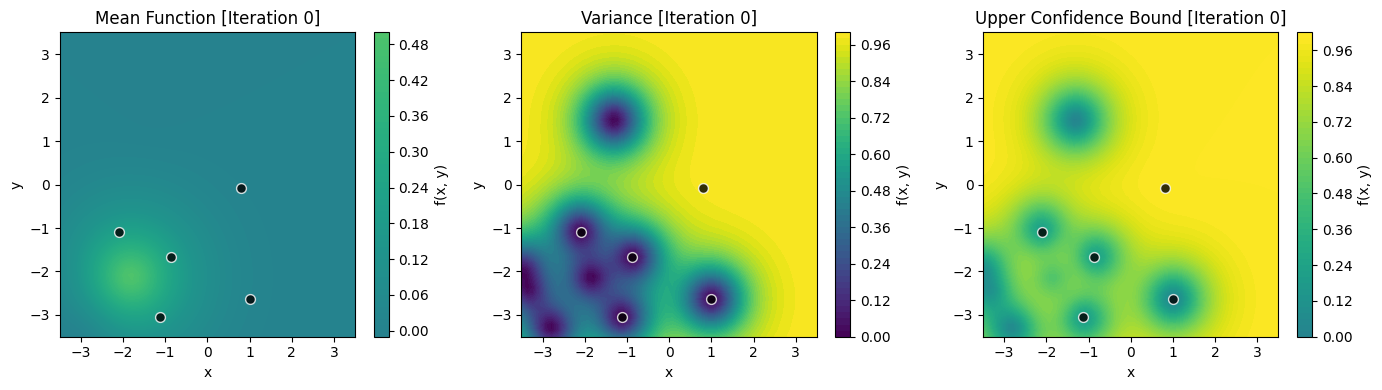

The sampled value so far : 0.49618551500772584


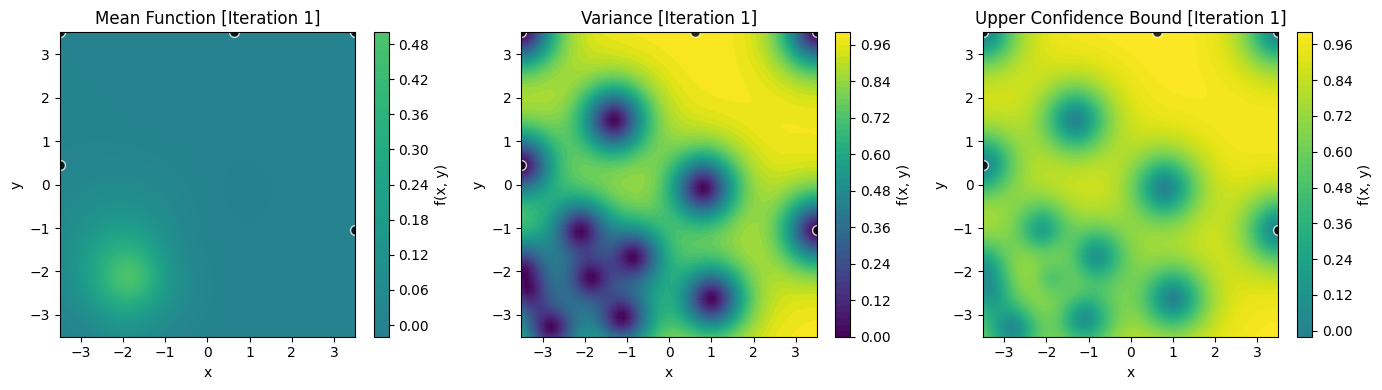

The sampled value so far : 0.8227553681528647


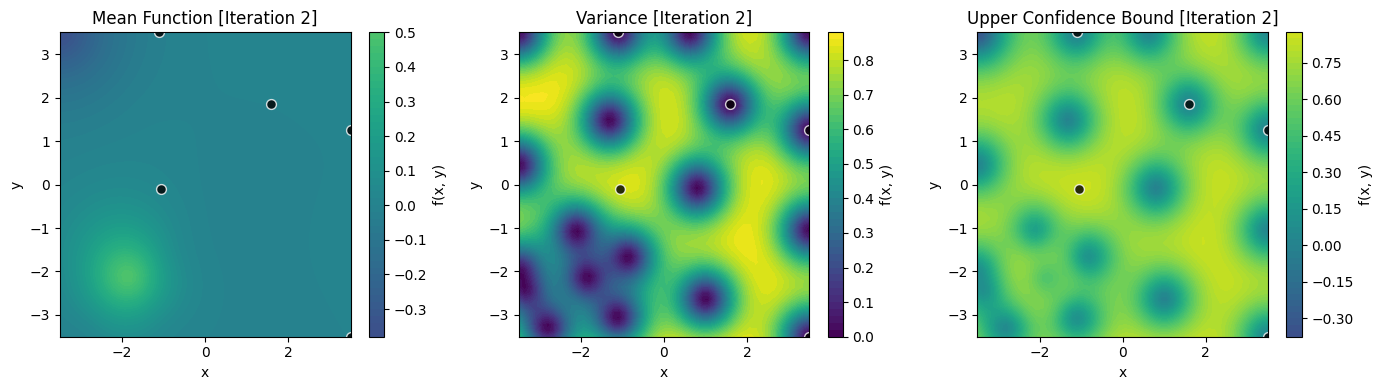

The sampled value so far : 0.8912214431449718


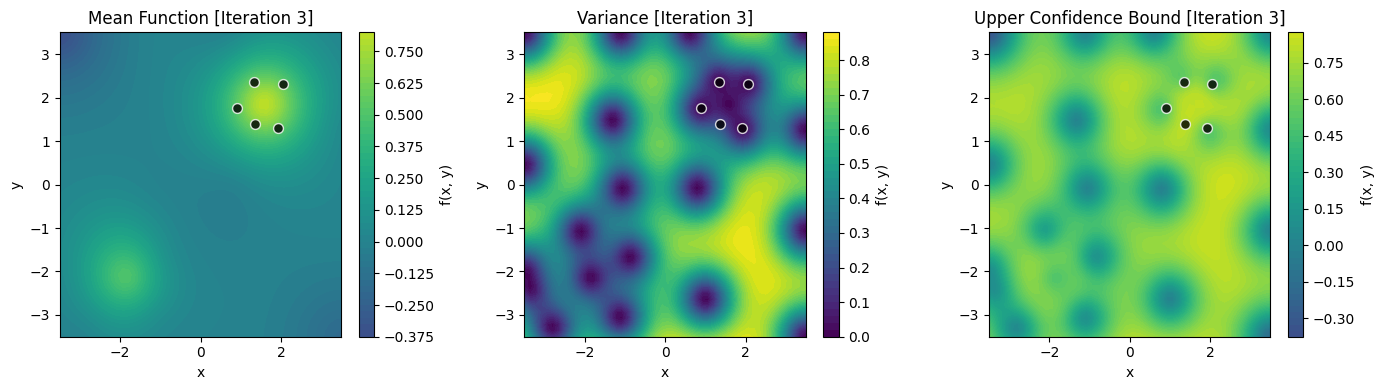

The sampled value so far : 0.9891002064771485


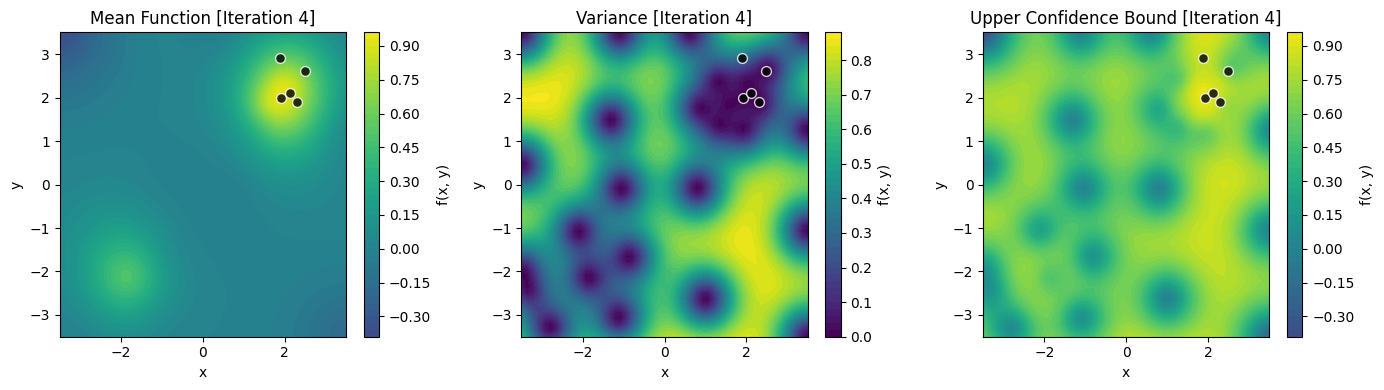

(25,) (30,)


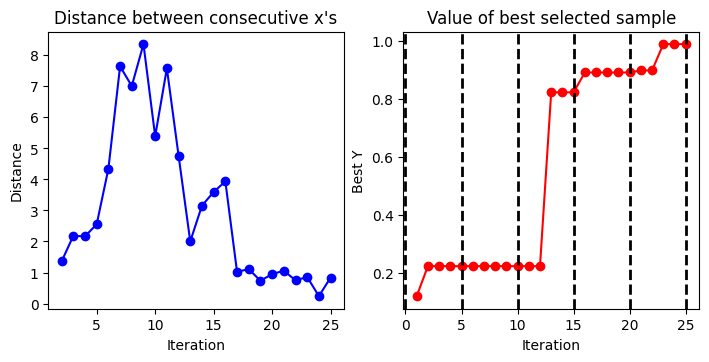

In [11]:
if __name__ == "__main__":
    name_acquisition = "batch_upper_confidence_bound"
    name_kernel = "matern32"
    seed = 1234567
    length_scale = 1.0
    iter = 5
    n_batch = 5
    insight = True
    bayesian_optimisation = pipeline(name_acquisition=name_acquisition, name_kernel=name_kernel, seed=seed, length_scale=length_scale, iter=iter, n_batch=n_batch, insight=insight)